<a href="https://colab.research.google.com/github/kjm90110/course-manage-program/blob/master/1_LightBGM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LightGBM (Light Gradient Boosting Machine)**

### 📖 1. 개요
**LightGBM**은 마이크로소프트에서 개발한 빠르고 효율적인 그래디언트 부스팅 프레임워크입니다. 기존의 GBDT(Gradient Boosting Decision Tree)의 단점을 개선하여 더 빠른 학습 속도와 낮은 메모리 사용량을 제공합니다.

#### 주요 특징

- ⚡ 빠른 학습 속도: 리프 중심 트리 성장으로 더 효율적
- 💾 메모리 효율성: 기존 부스팅 대비 1/20 수준의 메모리 사용
- 📊 대용량 데이터 최적화: 수백만 개의 데이터 행 처리 가능
- 🎯 범주형 특성 자동 처리: 인코딩 없이 범주형 데이터 직접 입력
- 🚀 병렬 & GPU 지원: 멀티스레딩 및 GPU 가속 가능

#### 사용 사례

- 클릭 예측 (CTR Prediction)
- 추천 시스템
- 이탈률 예측
- 금융 신용 평가
- 의료 진단 보조

### 2. 핵심 원리
알고리즘 동작 방식


```
1단계: 초기 예측값 설정
   F₀(x) = log(positive_samples / negative_samples)

2단계: 반복 (t = 1 to T)
   - 이전 예측의 잔차(residual) 계산
   - 잔차를 예측하는 새로운 결정 트리 구축
   - 학습률을 적용하여 예측값 업데이트
   - Fₜ(x) = Fₜ₋₁(x) + learning_rate × hₜ(x)

3단계: 최종 예측
   F(x) = F₀(x) + Σ(learning_rate × hₜ(x))
```

## 리프 중심(Leaf-wise) 성장
#### LightGBM은 리프 중심 트리 성장 방식을 사용합니다.

- 레벨 중심(Level-wise): 트리의 모든 리프를 같은 깊이까지 성장 → 균형잡힌 트리
- 리프 중심(Leaf-wise): 손실을 가장 많이 줄이는 리프를 선택하여 성장 → 깊은 트리, 빠른 수렴

```
레벨 중심:          리프 중심:
      O                  O
     / \                / \
    O   O              O   O
   /|   |\            /|
  O O   O O          O O
                     /
                    O
```

## 특성 분할(Split) 선택
LightGBM은 **히스토그램 기반 학습**을 사용하여 정확도는 유지하면서 메모리와 속도를 개선합니다.

## 3. 장점과 단점
✅ 장점

1. 빠른 학습 속도: 다른 부스팅 모델보다 2-10배 빠름
2. 낮은 메모리 사용량: 히스토그램 기반 학습으로 메모리 효율적
3. 대용량 데이터 처리: 수백만 개 샘플도 빠르게 처리
4. 범주형 특성 지원: 인코딩 없이 직접 사용 가능
5. 병렬 처리 및 GPU 가속: 빠른 학습 가능
6. 우수한 성능: 많은 kaggle 대회에서 우승

❌ 단점

1. 과적합 위험: 리프 중심 성장으로 깊은 트리가 될 수 있음
작은 데이터셋 성능
2. 저하: 10,000개 이하 샘플에서 성능 악화 가능
3. 하이퍼파라미터 민감성: 튜닝이 많이 필요할 수 있음
4. 범주형 특성 처리: 범주의 수가 많으면 성능 저하

## 💻 5. Google Colab 실습 코드

### 단계 1: 라이브러리 설치 및 import

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report)
from lightgbm import LGBMClassifier
import warnings

In [ ]:
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

### 단계 2: 데이터 로드 및 전처리

In [ ]:
# Breast Cancer 데이터셋 로드
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target

print(f"데이터셋 정보:")
print(f"  - 샘플 수: {X.shape[0]}")
print(f"  - 특성 수: {X.shape[1]}")
print(f"  - 클래스 분포: {np.bincount(y)}")
print(f"  - 특성 이름: {cancer.feature_names[:5]}...")

데이터셋 정보:
  - 샘플 수: 569
  - 특성 수: 30
  - 클래스 분포: [212 357]
  - 특성 이름: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness']...


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n✅ 데이터 분할 완료:")
print(f"  - 훈련 데이터: {X_train.shape[0]} 샘플")
print(f"  - 테스트 데이터: {X_test.shape[0]} 샘플")


✅ 데이터 분할 완료:
  - 훈련 데이터: 455 샘플
  - 테스트 데이터: 114 샘플


### 단계 3: LightGBM 모델 생성 및 학습

In [ ]:
# LightGBM 분류 모델 생성
lgb_model = LGBMClassifier(
    n_estimators=200, # 부스팅 라운드
    learning_rate=0.05, # 학습률 (낮을수록 느리지만 정확)
    num_leaves=31, # 최대 리프 수
    max_depth=7, # 최대 깊이
    min_data_in_leaf=20,# 리프의 최소 샘플 수
    feature_fraction=0.8,# 특성 샘플링
    bagging_fraction=0.8,# 데이터 샘플링
    bagging_freq=5, # 5 라운드마다 샘플링
    lambda_l1=0.1,# L1 정규화
    lambda_l2=0.1, # L2 정규화
    random_state=42,
    verbose=-1
)

In [ ]:
print('LightBGM 모델 학습 중..')
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)], # 검증 데이터셋
    callbacks=[
        # 과적합 방지를 위해 검증 성능이 10라운드 동안 개선되지 않으면 조기 종료
        # (주석 처리 - Colab에서 호환성 문제가 있을 수 있음)
    ]
)

print("✅ 학습 완료!")

LightBGM 모델 학습 중..
✅ 학습 완료!


In [ ]:
y_pred_train = lgb_model.predict(X_train)
y_pred_test = lgb_model.predict(X_test)

# 성능 지표 계산
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

test_precision = precision_score(y_test, y_pred_test)
test_recall = recall_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test)

In [ ]:
print("=" * 50)
print("📊 LightGBM 모델 성능 평가")
print("=" * 50)
print(f"\n정확도 (Accuracy):")
print(f"  - 훈련 데이터: {train_accuracy:.4f}")
print(f"  - 테스트 데이터: {test_accuracy:.4f}")

print(f"\n테스트 데이터 상세 평가:")
print(f"  - 정밀도 (Precision): {test_precision:.4f}")
print(f"  - 재현율 (Recall): {test_recall:.4f}")
print(f"  - F1-Score: {test_f1:.4f}")

print(f"\n분류 리포트:")
print(classification_report(y_test, y_pred_test,
                            target_names=['음성(0)', '양성(1)']))

# 혼동 행렬 (Confusion Matrix)
cm = confusion_matrix(y_test, y_pred_test)
print(f'\n혼동 행렬:')
print(cm)

📊 LightGBM 모델 성능 평가

정확도 (Accuracy):
  - 훈련 데이터: 1.0000
  - 테스트 데이터: 0.9474

테스트 데이터 상세 평가:
  - 정밀도 (Precision): 0.9459
  - 재현율 (Recall): 0.9722
  - F1-Score: 0.9589

분류 리포트:
              precision    recall  f1-score   support

       음성(0)       0.95      0.90      0.93        42
       양성(1)       0.95      0.97      0.96        72

    accuracy                           0.95       114
   macro avg       0.95      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114


혼동 행렬:
[[38  4]
 [ 2 70]]


### 단계 5: 시각화

Text(0.5, 10.722222222222216, '예측 값')

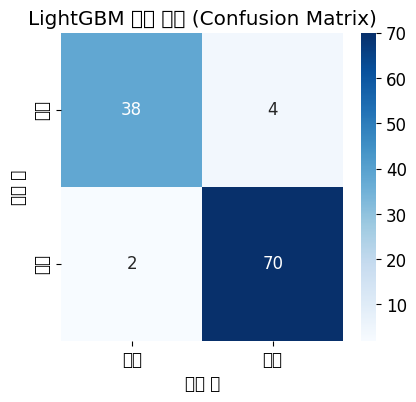

In [ ]:
# 1. 혼동 행렬 시각화
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['악성', '양성'],
            yticklabels=['악성', '양성'])
plt.title('LightGBM 혼동 행렬 (Confusion Matrix)')
plt.ylabel('실제 값')
plt.xlabel('예측 값')

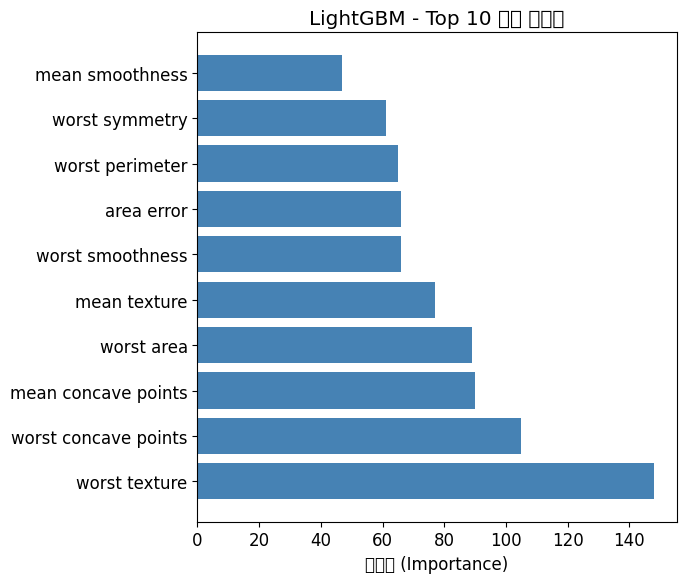


🔝 Top 10 중요 특성:
  1. worst texture: 148.0000
  2. worst concave points: 105.0000
  3. mean concave points: 90.0000
  4. worst area: 89.0000
  5. mean texture: 77.0000
  6. worst smoothness: 66.0000
  7. area error: 66.0000
  8. worst perimeter: 65.0000
  9. worst symmetry: 61.0000
  10. mean smoothness: 47.0000


In [ ]:
# 2. 특성 중요도 (Feature Importance) 시각화
plt.subplot(1, 2, 2)
feature_importance = lgb_model.feature_importances_
top_n = 10
top_indices = np.argsort(feature_importance)[-top_n:][::-1]

plt.barh(range(top_n), feature_importance[top_indices], color='steelblue')
plt.yticks(range(top_n), [cancer.feature_names[i] for i in top_indices])
plt.xlabel('중요도 (Importance)')
plt.title(f'LightGBM - Top {top_n} 특성 중요도')
plt.tight_layout()
plt.show()

print(f"\n🔝 Top 10 중요 특성:")
for rank, idx in enumerate(top_indices, 1):
    print(f"  {rank}. {cancer.feature_names[idx]}: {feature_importance[idx]:.4f}")

### 단계 6: 학습 곡선 시각화

In [ ]:
# 반복 횟수에 따른 성능 변화
# (만약 eval_set에서 evals_result를 저장했다면 사용 가능)

plt.figure(figsize=(10, 5))

# 간단한 버전: 여러 n_estimators로 비교
estimators_list = [10, 50, 100, 200, 300]
train_accs = []
test_accs = []

for n_est in estimators_list:
  temp_model = LGBMClassifier(
      n_estimators=n_est,
      learning_rate=0.05,
      num_leaves=31,
      random_state=42,
      verbose=-1
  )

  temp_model.fit(X_train, y_train)

  train_accs.append(accuracy_score(y_train, temp_model.predict(X_train)))
  test_accs.append(accuracy_score(y_test, temp_model.predict(X_test)))

<Figure size 1000x500 with 0 Axes>

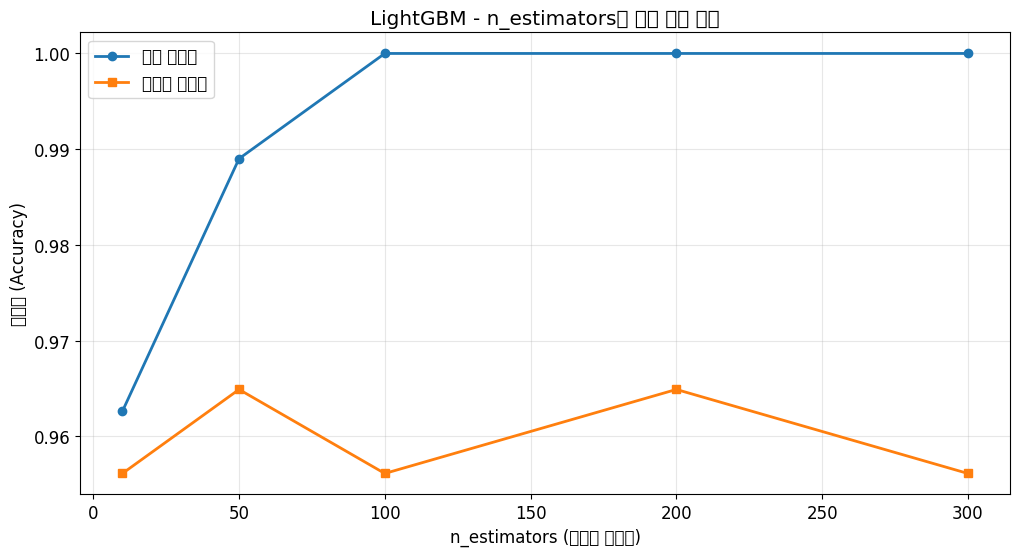

In [ ]:
plt.plot(estimators_list, train_accs, marker='o', label='훈련 정확도', linewidth=2)
plt.plot(estimators_list, test_accs, marker='s', label='테스트 정확도', linewidth=2)
plt.xlabel('n_estimators (부스팅 라운드)')
plt.ylabel('정확도 (Accuracy)')
plt.title('LightGBM - n_estimators에 따른 성능 변화')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 📚 6. 주요 개념 정리
#### **그래디언트 부스팅 (Gradient Boosting)**
여러 개의 약한 학습기(weak learner, 보통 결정 트리)를 **순차적으로 결합하여 강한 학습기(strong learner)를 만드는 앙상블 기법**입니다.
#### **부스팅 (Boosting)**
이전 모델의 오류를 다음 모델이 학습하도록 하는 방식입니다.
#### **정규화 (Regularization)**
과적합을 방지하기 위해 모델의 복잡도에 페널티를 부여합니다.

- L1 정규화: 계수를 0으로 만들어 특성 선택
- L2 정규화: 계수의 크기를 작게 제약

## 🎯 7. 실전 팁

1. 데이터 크기: LightGBM은 10,000개 이상의 샘플에서 성능이 좋습니다.
2. 범주형 특성: 문자열 범주형도 직접 입력 가능합니다.
3. 클래스 불균형: scale_pos_weight 파라미터로 조정합니다.
4. 조기 종료: 검증 성능이 개선되지 않으면 학습을 멈춥니다.
5. GPU 가속: device='gpu' 파라미터로 GPU 사용 가능합니다.